# Convolutions

In the lectures and the problem sets, you learned how to evaluate convolutions analytically.  In this notebook, I'll show you how to work them out numerically in python giving you a useful way to check homework answers.   Then, I'll show some applications of the convolution theorem. 

## Finding Convolutions

To convolve two functions, you have to evaluate 
$$ (f \otimes g)(x) = \int_{-\infty}^\infty f(x) g(x-u) du.$$
As you've found in the homeworks, sometimes this can be tricky, but this is very easy numerically.  In the example below, I convolve a Gaussin with a step function to give me a smoothed step function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps
import scipy.linalg as spl
import scipy.fft as spf
from matplotlib import image
import time

xv,yv = np.linspace(-10,10,500), np.linspace(-10,10,500)
X,Y = np.meshgrid(xv,yv)

In [2]:
def signal(x):
    ret = np.zeros_like(x)
    ret[np.abs(x)<5] = 1.0
    return ret

def impulse(x):
    return np.exp(-x**2)

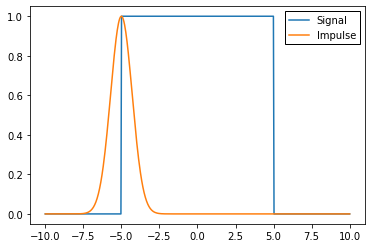

In [3]:
plt.figure()
plt.plot(xv, signal(xv), label="Signal")
plt.plot(xv, impulse(xv+5), label="Impulse")
plt.legend(fancybox=False, edgecolor="k", framealpha=1)

plt.show()

In [4]:
filtered = sps.convolve(signal(xv), impulse(xv), mode='same', method="fft") / np.sum(impulse(xv))

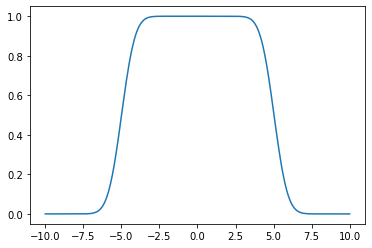

In [5]:
plt.figure()
plt.plot(xv,filtered)
plt.show()

Now we'll take an example from the practice problems.
We'll convolve 
\begin{equation}
    f(x) = 
    \begin{cases}
        1, \ |x| < 1 \\
        0, \ \text{otherwise}
    \end{cases}
\end{equation}
with 
\begin{equation}
    g(x) = 
    \begin{cases}
        x, \ 0 < x < 1 \\
        0, \ \text{otherwise} .
    \end{cases}
\end{equation}
We know what to expect of this from the practice problem 
\begin{equation}
    (f\otimes g)(x) = 
    \begin{cases}
        0, \ x < 1 \\
        \frac{1}{2}(x + 1)^2, \ -1 < x < 0 \\
        \frac{1}{2} \ 0 < x < 1 \\
        x - \frac{x^2}{2} \ 1 < x < 2 \\
        0 \ x > 2 
    \end{cases}
\end{equation}
but let's see what we get numerically.
You'll notice that the normalisations are slightly different.  When we work out convolutions numerically, the result is normalised to range from 0 to 1.

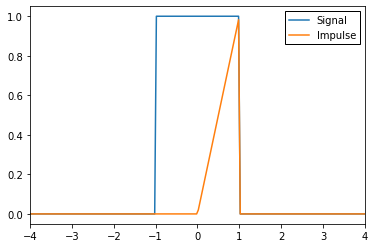

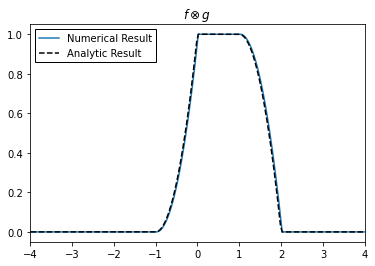

In [6]:
def signal(x):
    ret = np.zeros_like(x)
    ret[np.abs(x)<1] = 1.0
    return ret

def impulse(x):
    ret = np.zeros_like(x)
    mask = np.logical_and(np.abs(x)<1, x>0)
    ret[mask] = x[mask]
    return ret

def analytic_result(x):
    ret = np.zeros_like(x)
    ret[x<-1] = 0.0
    ret[np.logical_and(x>-1, x<0)] = 0.5*(x[np.logical_and(x>-1, x<0)] + 1)**2
    ret[np.logical_and(x>0, x<1)] = 0.5
    ret[np.logical_and(x>1, x<2)] = x[np.logical_and(x>1, x<2)] - x[np.logical_and(x>1, x<2)]**2/2.0
    ret[x>2] = 0.0
    return ret

plt.figure()
plt.plot(xv, signal(xv), label="Signal")
plt.plot(xv, impulse(xv), label="Impulse")
plt.xlim(-4,4)
plt.legend(fancybox=False, edgecolor="k", framealpha=1)

filtered = sps.convolve(signal(xv), impulse(xv), mode='same', method="fft") / np.sum(impulse(xv))

plt.figure()
plt.plot(xv,filtered, label="Numerical Result")
plt.plot(xv,2.0*analytic_result(xv), 'k--', label="Analytic Result")
plt.title("$f \otimes g$")
plt.xlim(-4,4)
plt.legend(fancybox=False, edgecolor="k", framealpha=1)

plt.show()

## Application: Circulant Matrices

We also learned about the convolution theorem, which states that the Fourier transform of a convolution is just the product of the Fourier transforms of the two functions
$$\mathcal{F}[f \otimes g] = \mathcal{F}[f] \mathcal{F}[g].$$
It turns out this can be used to speed up solving certain linear systems.  There is a special type of matrix called a circulant matrix that has the structure 
\begin{equation}
C = 
\begin{pmatrix}
    c_0 & c_{n-1} & \cdots & c_2 & c_1 \\
    c_1 & c_0 & c_{n-1} & & c_2 \\
    \vdots & c_1 & c_0 & \ldots & \vdots \\
    c_{n-2} & & \ldots & \ldots & c_{n-1} \\
    c_{n-1} & c_{n-2} & \cdots & c_1 & c_0  
\end{pmatrix} .
\end{equation}
If you have the linear system
$$\boldsymbol{C} \boldsymbol{x} = \boldsymbol{b},$$
where $\boldsymbol{C}$ is circulant we can note that the elements of $c_{ij}$ only depend upon the difference of their indices $c_{i-j}$ so that the linear system is 
$$\sum_j c_{i-j} x_j = b_i,$$
which is just a convolution!  We can also realise that a circulant matrix can be generated from only the first column.  This means that the linear system can be written as 
$$\boldsymbol{c} \otimes \boldsymbol{x} = \boldsymbol{b}$$
where $\boldsymbol{c}$ is the first column of the circulant matrix $C$.  To this we can apply the colvolution theorem to find $\boldsymbol{x}$
\begin{align}
    \boldsymbol{c} \otimes \boldsymbol{x} &= \boldsymbol{b} \\
    \mathcal{F}[\boldsymbol{c} \otimes \boldsymbol{x}] &= \mathcal{F}[\boldsymbol{b}] \\
    \mathcal{F}[\boldsymbol{c}] \mathcal{F}[\boldsymbol{x}] &= \mathcal{F}[\boldsymbol{b}] \\
    \boldsymbol{x} &= \mathcal{F}^{-1} \left[ \frac{\mathcal{F}[\boldsymbol{b}]}{\mathcal{F}[\boldsymbol{c}]} \right] .
\end{align}
This converts a matrix inversion into three Fourier transforms.  Since numerically evaluating [Fourier transforms](https://en.wikipedia.org/wiki/Cooley–Tukey_FFT_algorithm) has complexity $\mathcal{O}(N \log N)$, while solving a linear system using standard methods has complexity $\mathcal{O}(N^{3})$, this can provide a significant speed up when solving large systems providing the matrix is cirulant.
This technique is, for example, to model materials made of [several dipoles](https://doi.org/10.1364/OL.16.001198) arranged in a regular array.
In the code below we'll try this out and see where it really is any faster.  Scipy's linear algebra library has a function for constructing circulant matrices.

In [7]:
N = 3000 
col = np.random.random(N)
b = np.random.random(N)
A = spl.circulant(col)

t0 = time.time()
x_direct = spl.solve(A, b)
t1 = time.time()
print("Direct solve time = %lf s" %(t1-t0))

t0 = time.time()
x_fft = spf.ifft(spf.fft(b)/spf.fft(col))
t1 = time.time()
print("Convolution method solve time = %lf s" %(t1-t0))

error = np.sum( np.abs(x_direct - x_fft) )
print("Difference between solutions = %g" %(error))

Direct solve time = 0.548345 s
Convolution method solve time = 0.000736 s
Difference between solutions = 9.42903e-12


We see that using two Fourier transforms rather than a direct solution speeds things up a lot!

## Application: Image Smoothing

Another use of convolutions is to smooth images.  We saw at the start of the notebook that convolving a Gaussian with a step function smoothed the step function; image smoothing uses exactly the same idea.  Sharp features of the image are smeared by the convolution.

In the code below, we'll take a grainy image and smooth it out by convolving it with a Gaussain.

float64 (633, 1024)


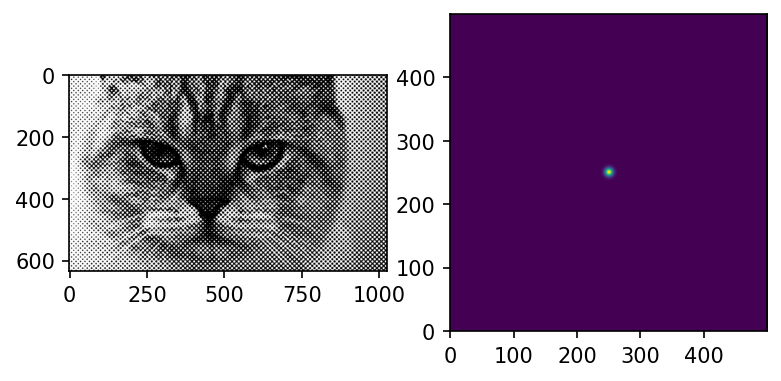

In [8]:
# Load in the image and convert it to greyscale
def rgb2grey(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = image.imread("cat.jpg")
img = rgb2grey(img) # Convert to greyscale
print(img.dtype, img.shape)

# The Gaussian pulse we'll use to smooth things
def impulse(x,y):
    s = 0.25
    return np.exp(-x**2/s**2)*np.exp(-y**2/s**2)

fig,axs = plt.subplots(1,2, dpi=150)
axs[0].imshow(img, cmap='gray')
axs[1].imshow(impulse(X,Y), origin="lower")

plt.show()

In [9]:
# Evaluate the convolution, as before
filtered = sps.convolve(img, impulse(X,Y), mode='same', method="fft") / np.sum(impulse(X,Y))

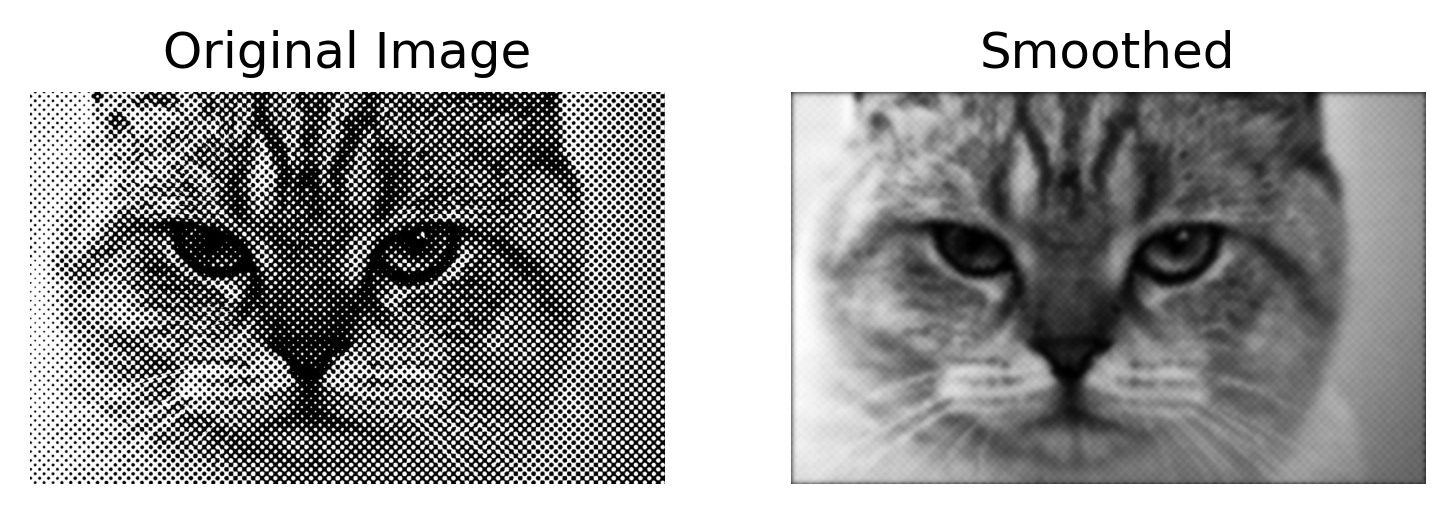

In [10]:
fig,axs = plt.subplots(1,2, dpi=300)
axs[0].imshow(img, cmap='gray')
axs[0].axis("off")
axs[0].set_title("Original Image")
axs[1].imshow(filtered, cmap='gray')
axs[1].axis("off")
axs[1].set_title("Smoothed")
plt.show()